## Import data

Tyrosine Kinases ligands with bioactivity data, by Ricardo Romero Ochoa on kaggle
Small compounds targeting tyrosine kinases, curated from the ChEMBL database
28314 small compounds

Ricardo Romero Ochoa. (2024). Tyrosine Kinases ligands with bioactivity data [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/8626441

The data can be used to train models that predict or classify bioactivity and druglike properties of small compounds targeting a tyrosine kinase protein.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

drugs_dataset = pd.read_csv("./kinase_data_final_tox.csv")

In [2]:
# Get a sense of the data
drugs_dataset

,molecule_chembl_id,canonical_smiles,IC50,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50,target,Druglikeness,Mutagenic,Tumorigenic,Reproductive Effective,Irritant
0,CHEMBL4557543,COc1cc(OC)c(Cl)c(-c2ccc3c(NC(=O)c4ccc(N5CCN(C)...,14.00,active,575.884,5.60640,2,7,7.853872,FGFR,8.89410,none,high,high,none
1,CHEMBL3904778,C=CC(=O)Nc1cccc(Oc2nc(Nc3ccc(OC)cc3OC)ncc2Br)c1,65.00,active,471.311,4.91670,2,7,7.187087,EGFR,-10.11200,high,low,low,low
2,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,10000.00,inactive,340.637,5.04890,0,2,5.000000,EGFR,0.70500,none,none,none,none
3,CHEMBL604712,CC(C)(C)C(=O)N1Cc2c(NC(=O)c3cc(F)cc(F)c3)n[nH]...,10000.00,inactive,376.407,3.56360,2,3,5.000000,ABL,1.01070,none,none,none,none
4,CHEMBL556684,COc1cc(O)c2c(c1)C(=O)c1cc(C)c(O)c(O)c1C2=O,4.00,active,300.266,1.89582,3,6,8.397940,EGFR,-0.97635,low,none,none,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28309,CHEMBL1822773,COc1ccc(CCC(=O)N/N=C2\C(=O)Nc3c(Cl)ccc(Cl)c32)cc1,2000.00,intermediate,392.242,3.40720,2,4,5.698970,MET,4.21000,none,high,high,low
28310,CHEMBL366580,Brc1cccc(Nc2ncnc3cc4c[nH]nc4cc23)c1,0.34,active,340.184,4.01220,2,4,9.468521,EGFR,1.30470,high,none,none,none
28311,CHEMBL2408503,O=C(COc1cc(O)c2c(=O)cc(-c3ccccc3)oc2c1)Nc1cccc...,17600.00,inactive,466.287,4.94560,2,5,4.754487,ABL,0.33822,none,none,none,none
28312,CHEMBL1725279,Oc1c2ccccc2c2c3c(cccc13)N=N2,957.00,active,220.231,4.42740,1,3,6.019088,JAK,-5.87440,high,high,none,high


but the loaded dataset contains 21441 compounds

## About the dataset
- molecule_chembl_id: Identifier for the compound
- canonical_smiles: Simplified Molecular Input Line Entry System, used to describe molecular structure.
- IC50: concentration of a drug required to reduce the biological process by 50%
- class: Inactive (IC50 >= 10 000 nm); Active (IC50 =< 1000 nm); Intermediate (1000 < IC50 < 10 000 nm)
(IC50 > 10^9 nM) were converted to 1
- MW: molecular weight
- LogP: Water-octanol partition coefficient. Indicative of a compound's hydrophobicity/lipophilicity. logarithm of the ratio of a compound's concentration in octanol to its concentration in water. Greater logP means more lipophilic & non-polar compound.
- NumHDonors: Number of Hydrogen bond donors
- NumHAcceptors: Number of Hydrogen bond acceptors
- pIC50: -log10(IC50); larger pIC50 means more effective drug
- target: the tyrosine kinase(s) targeted by the compound
- Druglikeness: similarity of properties between the compound and existing drugs
- Mutagenic, Tumorigenic, Reproductive Effective, Irritant


In [3]:
import seaborn as sns

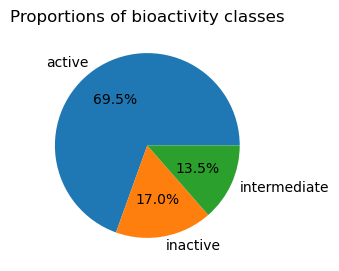

In [95]:
class_counts = drugs_dataset['class'].value_counts()
class_counts.plot(kind='pie', autopct='%1.1f%%', labels=class_counts.index, figsize=(3, 3))
plt.title('Proportions of bioactivity classes')
plt.ylabel('')
plt.show()

If our neural net guesses blindly, it will be correct 69.5% of the time. So our accuracy needs to be > 70%

In [89]:
drugs_dataset.groupby('class').sum().plot(kind='pie', y='votes_of_each_class')


KeyError: 'votes_of_each_class'

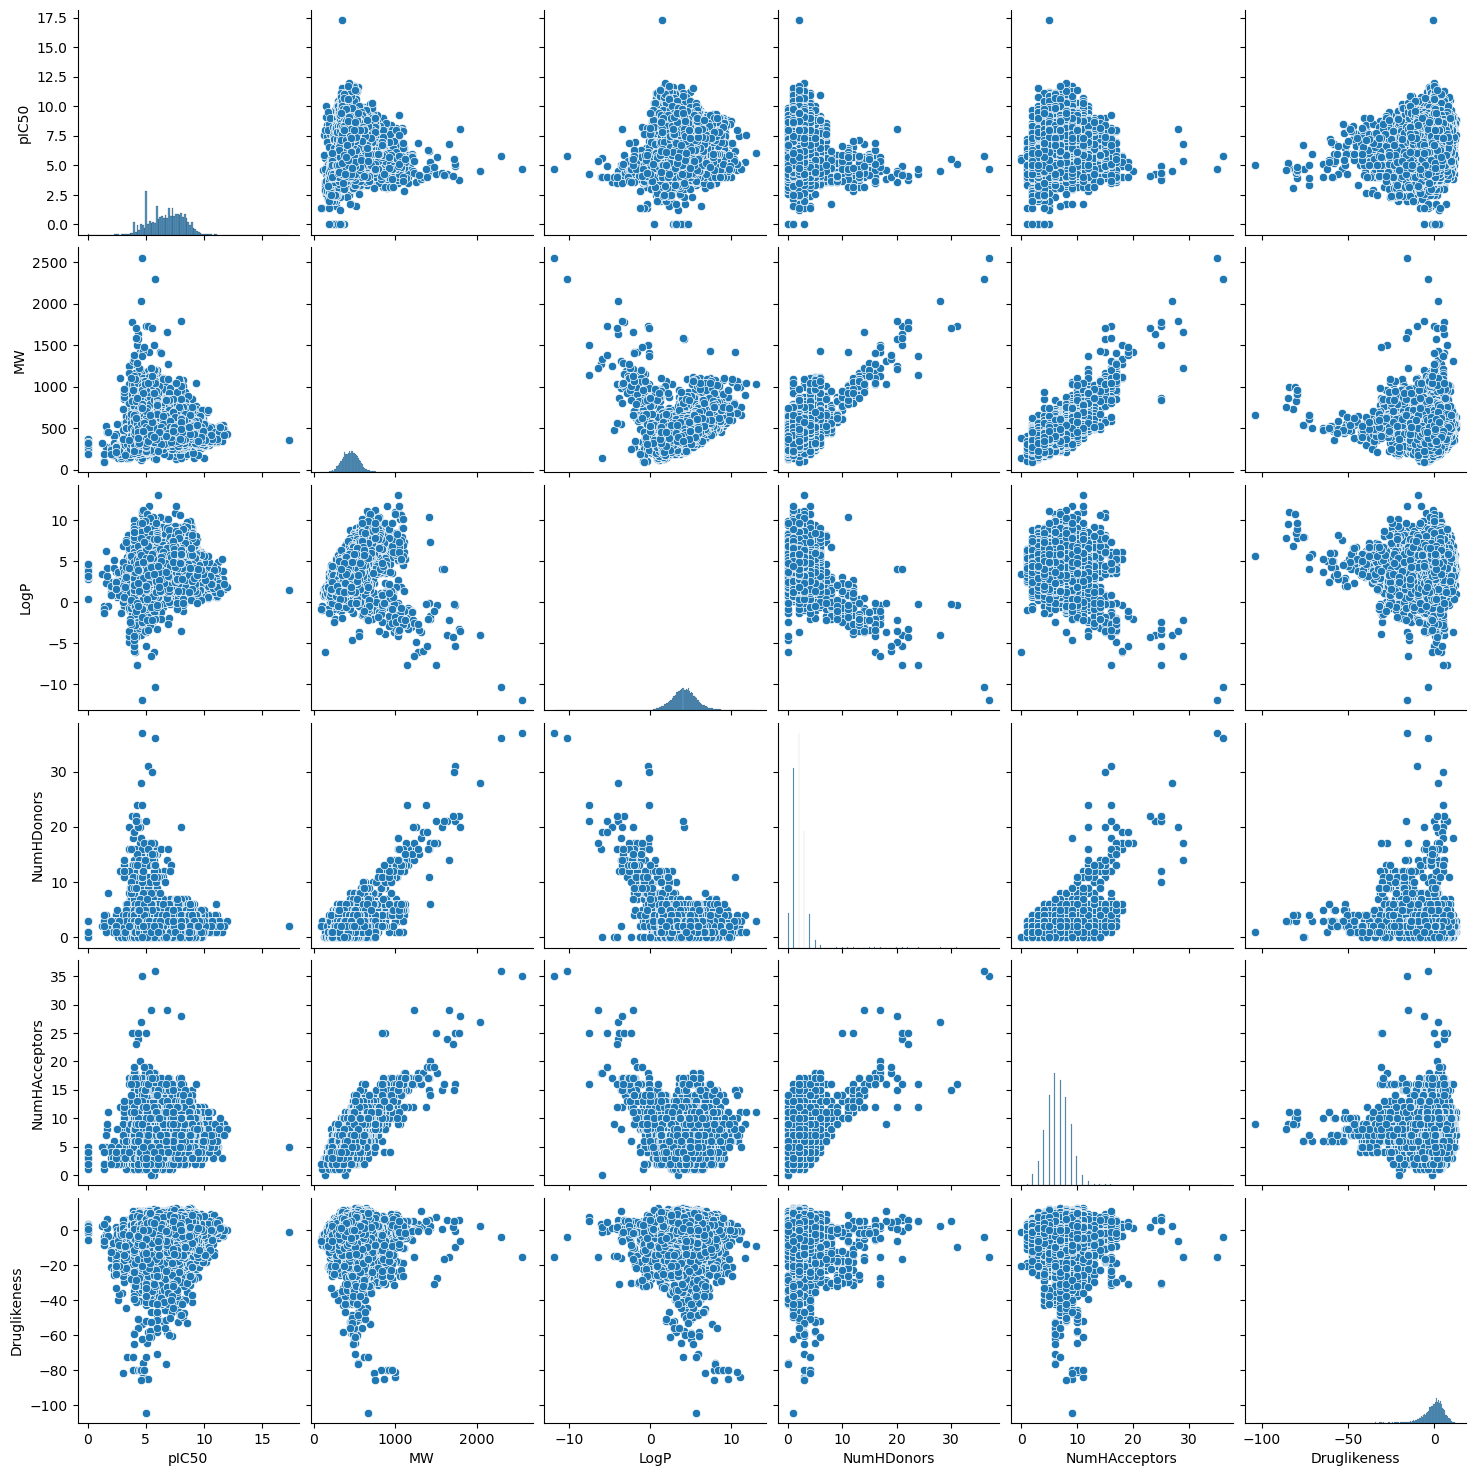

In [4]:
subset = drugs_dataset[["pIC50", "MW", "LogP", "NumHDonors", "NumHAcceptors", "Druglikeness"]]
sns.pairplot(subset)

## Aims & goals

Aim: train a model to predict how well a given compound targets receptor tyrosine kinases.

Strategy A: 
- Input: chemical structure of the compound
- Label/Output: class (inactive, intermediate, active)

Strategy B:
- Input: chemical structure of the compound
- Output: IC50 value

Strategy A is a classification problem, while Strategy B is a regression problem. I will attempt both. 

## Data preprocessing

### Molecular fingerprints

To convert the chemical structures into more appropriate inputs for the neural network, we will generate molecular fingerprints for each compound. We do so by applying a kernel to a molecule, which generates a bit or count vector. This is done using the package RDKit.
https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf

In [5]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

In [ ]:
""" # Convert the canonical_smiles strings to RDKit molecules
compounds = [Chem.MolFromSmiles(smiles) for smiles 
             in drugs_dataset['canonical_smiles']]

# Generate the Morgan fingerprints for each molecule
fingerprints = [Chem.RDKFingerprint(compound) for compound in compounds]

# Standarise input
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
fingerprints_scaled = scaler.fit_transform(fingerprints) 

# View & save scaled fingerprints, since scaling takes time
print(fingerprints_scaled[:5])
np.save('./fingerprints_scaled.npy', fingerprints_scaled) """

In [6]:
# Sanity check everything saved appropriately
fingerprints_scaled = np.load('./fingerprints_scaled.npy')

### Labels for bioactivity

In [103]:
activity_class = drugs_dataset["class"]

In [21]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
activity_encoded = label_encoder.fit_transform(activity_class)  # e.g., 'active' -> 0, 'inactive' -> 1, etc.
activity_1hot = to_categorical(activity_encoded)

### Define training & test sets

In [22]:
testset_size = round(fingerprints_scaled.shape[0] * 0.2) # 20% of the dataset is the test set

# Define test and training sets
test_x = fingerprints_scaled[:testset_size,:]
test_y = activity_1hot[:testset_size]

train_x = fingerprints_scaled[testset_size:,:]
train_y = activity_1hot[testset_size:]

In [ ]:
print(test_x.shape)
print(test_y.shape)
print(train_x.shape)
print(train_y.shape)

(5663, 2048)
(5663, 3)
(22651, 2048)
(22651, 3)


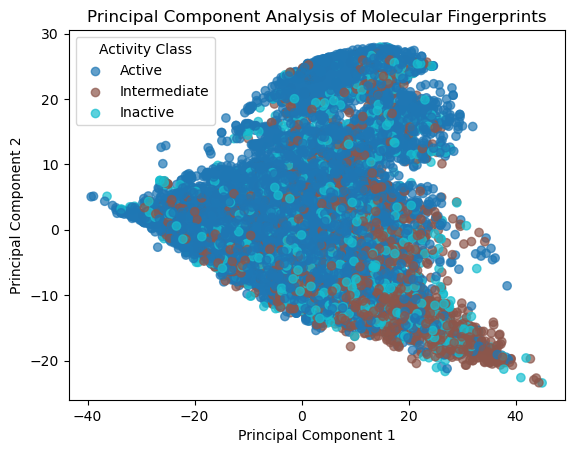

In [121]:
## Principal Component Analysis (PCA)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Run PCA
pca = PCA(n_components=20)
transformed = pca.fit_transform(fingerprints_scaled)

# Create scatter plot
scatter = plt.scatter(transformed[:, 0], transformed[:, 1], c=activity_encoded, cmap="tab10", alpha=0.7)

# Map encoded classes to labels
class_labels = {0: 'Active', 1: 'Intermediate', 2: 'Inactive'}
classes = np.unique(activity_encoded)
colors = scatter.cmap(scatter.norm(classes))

# Add dummy points for legend
for cls, color in zip(classes, colors):
    plt.scatter([], [], c=[color], label=class_labels[cls], alpha=0.7)

plt.legend(title="Activity Class")
plt.title('Principal Component Analysis of Molecular Fingerprints')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


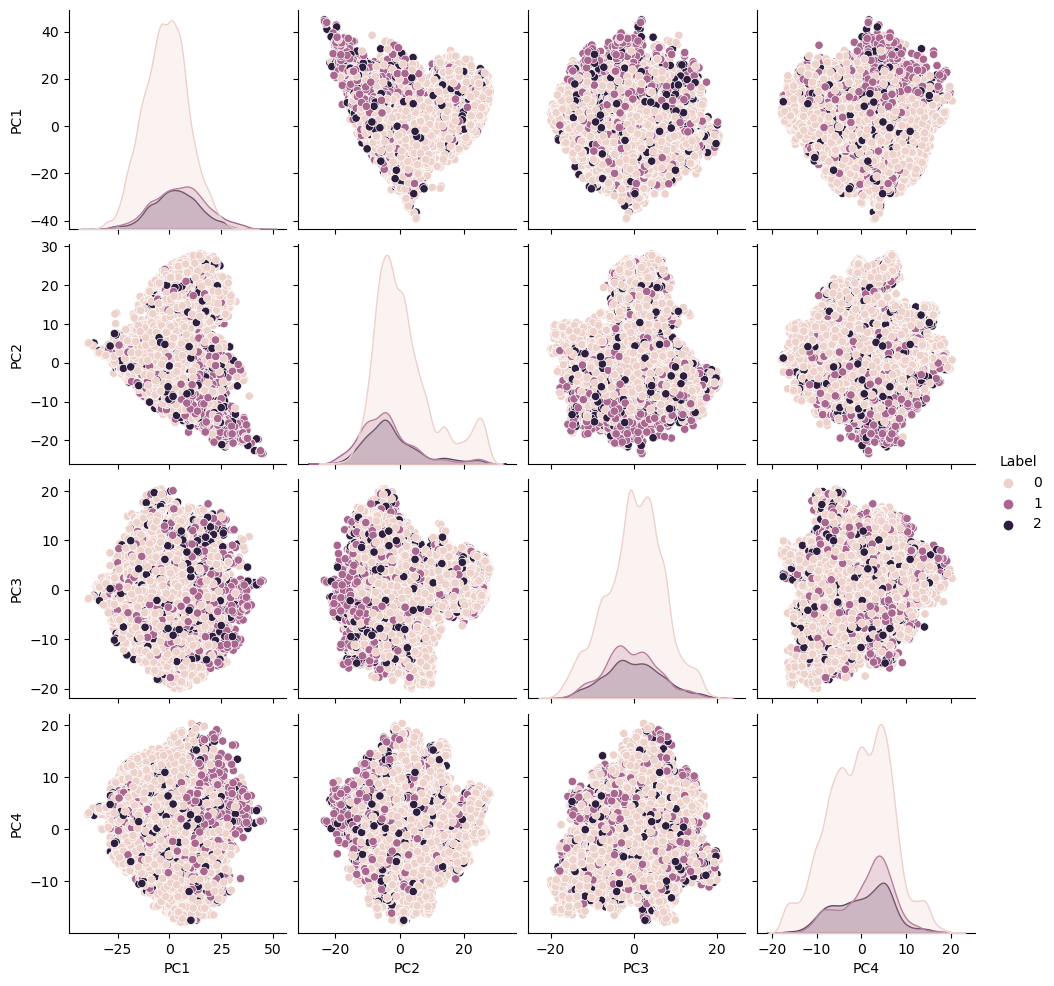

In [130]:
pca = PCA(n_components=4).fit_transform(fingerprints_scaled)
pca_df = pd.DataFrame(pca, columns=[f'PC{i+1}' for i in range(pca.shape[1])])

# Add the labels as a new column
pca_df['Label'] = activity_encoded

sns.pairplot(pca_df, hue='Label')

## Important parameters: 

- Learning rate: 
- Learning rate method: https://keras.io/api/optimizers/ 
- Activation function: linear, sigmoid, relu, softmax, tanh. Last layer will use softmax to determine which class is most likely

- Number of layers
- Number of nodes per layer
- epochs
- batch_size

- Loss function: https://keras.io/api/losses/
    - CategoricalCrossentropy class:  2 or more label classes, one_hot representation
    - CategoricalFocalCrossentropy: 2 or more label classes, one_hot representation. Handles class imbalance without using class_weights.
    - Sparse_categorical_crossentropy: integer labels, not appropriate for us.  

- Preventing overfitting: L1 or L2 regularisation

### Performance measures
- Correlation: not appropriate since we are predicting categorical variables based on non-numerical input
- PPV: Positive Predictive Value: No. of true positives/No. of true positives + No. of false positives
- F1: 2TP/(2TP + FP + FN)
- ROS: False positive vs. True positive; AUC: Area under the ROC curve 


Cross-validation: 20% test data, 60% training data, 20% validation data. 
k-fold cross validation: we will make 4 rounds of training-validation data



Optimise using Optuna?


## My model 1

In [ ]:
from tensorflow.keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
import keras

In [ ]:
num_classes = 3
epochs = 20
batch_size = 32

In [ ]:
model = Sequential()
model.add(Input(shape=train_x.shape[1:]))

model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='relu'))

model.add(Dense(num_classes, activation = 'softmax'))


In [ ]:
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

In [ ]:
# Let's train the model using RMSprop
model.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 20)                40980     
_________________________________________________________________
dense_25 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 63        
Total params: 41,463
Trainable params: 41,463
Non-trainable params: 0
_________________________________________________________________


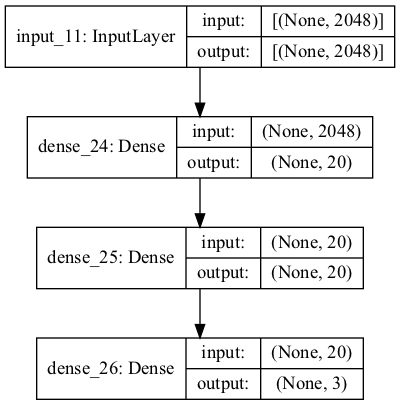

In [86]:
from keras.utils import plot_model
plot_model(model, "./simplenet_model.png", show_shapes=True)

In [88]:
hist = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
567/567 [==============================] - 1s 2ms/step - loss: 0.8390 - accuracy: 0.6350 - val_loss: 0.6908 - val_accuracy: 0.7305
Epoch 2/20
567/567 [==============================] - 1s 1ms/step - loss: 0.6366 - accuracy: 0.7502 - val_loss: 0.6214 - val_accuracy: 0.7557
Epoch 3/20
567/567 [==============================] - 1s 2ms/step - loss: 0.5708 - accuracy: 0.7767 - val_loss: 0.5880 - val_accuracy: 0.7663
Epoch 4/20
567/567 [==============================] - 1s 1ms/step - loss: 0.5255 - accuracy: 0.7956 - val_loss: 0.5682 - val_accuracy: 0.7738
Epoch 5/20
567/567 [==============================] - 1s 1ms/step - loss: 0.4894 - accuracy: 0.8106 - val_loss: 0.5531 - val_accuracy: 0.7828
Epoch 6/20
567/567 [==============================] - 1s 2ms/step - loss: 0.4597 - accuracy: 0.8204 - val_loss: 0.5407 - val_accuracy: 0.7888
Epoch 7/20
567/567 [==============================] - 1s 1ms/step - loss: 0.4342 - accuracy: 0.8331 - val_loss: 0.5324 - val_accuracy: 0.7925
Epoch 

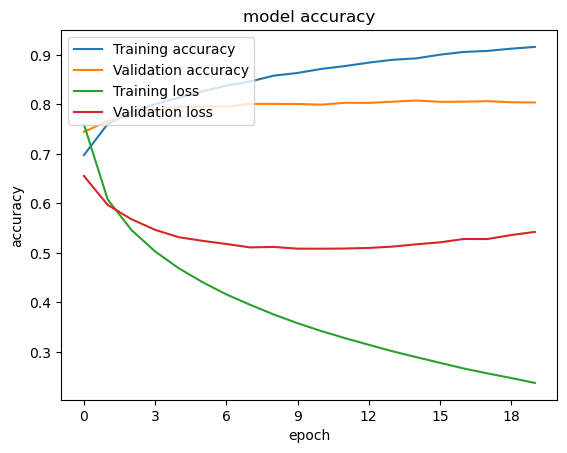

In [ ]:
from matplotlib.ticker import MaxNLocator

%matplotlib inline

def plot_loss_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Force integer ticks on x-axis

    plt.legend(['Training accuracy', 'Validation accuracy', 'Training loss', 'Validation loss'], loc='upper left')
    plt.show()
    
plot_loss_acc(hist)

In [ ]:
# Confusion matrix

## Architecture 2:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Conclusions
Which ML method?
Performance
Sensitivity to parameter choices
Ease of use

Other possible questions one could address with this dataset
- What is the compound's mutagenicity? none/low/high
- What is the compound's tumorigenecity?
- What is the compound's reproductive toxicity?
- What is the compound's irritation level?
- etc.